In [1]:
# Select algorithm to use as machine learner
# 0 = Linear Regression
# 1 = SVR  (not recommended - too slow)
# 2 = Decision Tree
# 3 = Random Forest
# 4 = XGBoost

algorithm_choice = 4

#Check a valid choice of algorithm has been made
assert algorithm_choice in [0,1,2,3,4]

In [2]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np
from nltk.stem import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print "Import successful"

Import successful


C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
try:
    data = pd.read_csv("train.csv")
    
    print "Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions training dataset has 404290 samples with 6 features each.


In [4]:
print "Display sample of training data:"
display(data.head(10))

Display sample of training data:


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
print "Display statistics about training data:"
display(data.describe())

Display statistics about training data:


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
#question ids not useful information
data.drop(['id', 'qid1', 'qid2'], axis = 1, inplace = True)

#data.dropna(how = "any", axis = 0, inplace = True)
nan_penalty = 100
print "Modified Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)

#split into features and results
results = data['is_duplicate']
features_raw = data.drop('is_duplicate', axis = 1)

#check training features and results are as expected
display(results.head())
display(features_raw.head())

Modified Quora duplicate questions training dataset has 404290 samples with 3 features each.


0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [7]:
from sklearn.feature_extraction import stop_words

def remove_stop_words(x):
    """Preprocess text to remove 'stopwords' from it (common words with little useful information)"""
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            if not word in stop_words.ENGLISH_STOP_WORDS:
                output += word + " "

        return output[:-1]
    except: #for the case of NaN entries
        return None

In [8]:
#Test that the remove_stop_words function works as expected
print remove_stop_words("Say hello to the cat")
print remove_stop_words("I am six years old")

 Say hello cat
 I years old


In [9]:
def to_lower_case(x):
    """Convert all text to lowercase"""
    try:
        return x.lower()
    except:
        return None

In [10]:
#Reference - http://www.nltk.org/howto/stem.html

stemmer = SnowballStemmer("english")

def stem_words(x):
    """Preprocess text to stem all words (e.g. remove plurals, verb ending, etc)"""
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            output += stemmer.stem(word) + " "

        return output[:-1]
    except: #for the case of NaN entries
        return None
    

In [11]:
test_words = ["hello", "running", "forgotten", "turned", "turns", "turning"]

for w in test_words:
    print(stemmer.stem(w))
    
test_sentence = "I am returning from running to the park after I ate some sandwiches quickly"
print stem_words(test_sentence)

hello
run
forgotten
turn
turn
turn
 i am return from run to the park after i ate some sandwich quick


In [12]:
### Data pre-processing ###

display(features_raw.head())

#Make all text lower case
features_raw["question1"] = features_raw["question1"].apply(to_lower_case)
features_raw["question2"] = features_raw["question2"].apply(to_lower_case)

#Remove stopwords
features_raw["question1"] = features_raw["question1"].apply(remove_stop_words)
features_raw["question2"] = features_raw["question2"].apply(remove_stop_words)

#Stem all words
features_raw["question1"] = features_raw["question1"].apply(stem_words)
features_raw["question2"] = features_raw["question2"].apply(stem_words)

display(features_raw.head())

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


,question1,question2
0,step step guid invest share market india?,step step guid invest share market?
1,stori kohinoor (koh-i-noor) diamond?,happen indian govern stole kohinoor (koh-i-no...
2,increas speed internet connect use vpn?,internet speed increas hack dns?
3,mental lonely? solv it?,"remaind [math]23^{24}[/math] divid 24,23?"
4,"dissolv water quik sugar, salt, methan carbon...",fish surviv salt water?


In [13]:
def diff_num_chars(x):
    """Create new feature - return the absolute difference in length of both questions, in terms of total number of chars"""
    try:
        len1 = len(x["question1"])
        len2 = len(x["question2"])
        return np.absolute(len1 - len2)
    except:
        #print x["question1"]    #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [14]:
def diff_num_words(x):
    """Create new feature - return the absolute difference in length of both questions, in terms of total number of words"""
    try:
        len1 = len(x["question1"].split())
        len2 = len(x["question2"].split())
        return np.absolute(len1 - len2)
    except:
        #print x["question1"]   #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [15]:
def num_common_words(x):
    """Create new feature - return the number of common words between both questions"""
    try:
        words1 = x["question1"].split()
        words2 = x["question2"].split()
        
        common_words = 0
        
        for word in words1:
            word_l = word
            if word in words2:
                common_words += 1
                
        return common_words
        
    except:
        #print x["question1"]  #print unexpected output for debug
        #print x["question2"]
        return 0

In [16]:
def ratio_common_words(x):
    """Create new feature - return ratio of common words between both questions"""
    try:
        return 1.0 * num_common_words(x) / (len(x["question1"].split()) + len(x["question2"].split()))
    except:
        return 0

In [17]:
features = pd.DataFrame()
features["diff_num_chars"] = features_raw.apply(diff_num_chars, axis=1)
features["diff_num_words"] = features_raw.apply(diff_num_words, axis=1)
features["num_common_words"] = features_raw.apply(num_common_words, axis=1)
features["ratio_common_words"] = features_raw.apply(ratio_common_words, axis=1)
display(features.head())

,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,6,1,5,0.384615
1,26,4,2,0.166667
2,7,1,3,0.272727
3,18,0,0,0.000000
4,32,5,0,0.000000


In [18]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
feature_list = ["diff_num_chars", "diff_num_words", "num_common_words", "ratio_common_words"]

scaled_data = min_max_scaler.fit_transform(features[feature_list])

features_scaled = pd.DataFrame(data = scaled_data, columns=feature_list)
display(features_scaled.head())
#display(test)

,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,0.010969,0.01,0.20,0.576923
1,0.047532,0.04,0.08,0.250000
2,0.012797,0.01,0.12,0.409091
3,0.032907,0.00,0.00,0.000000
4,0.058501,0.05,0.00,0.000000


In [19]:
from sklearn.cross_validation import train_test_split

#Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, results, test_size = 0.2, random_state = 17)

print "Training and testing split was successful."

Training and testing split was successful.


C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'STIXGeneral'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning C:\WINDOWS\Fonts\GOTHICB.TTF
  UserWarning)
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'STIXSizeOneSym'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal

C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'cmss10'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


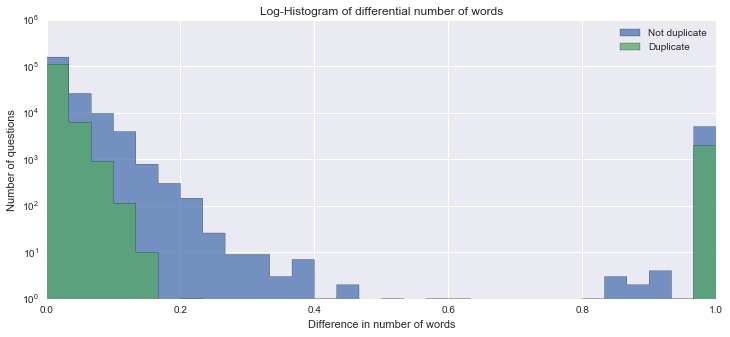

In [20]:
### Visualisation - plot histogram showing how distrubtion of differential number of words between both questions
### varies between duplicate and non-duplicate questions ###

# Histogram plotting techniques inspired by:
# https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_words"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label="Not duplicate")
plt.hist(X_train["diff_num_words"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of words')
plt.xlabel('Difference in number of words')
plt.ylabel('Number of questions')
plt.legend()
print

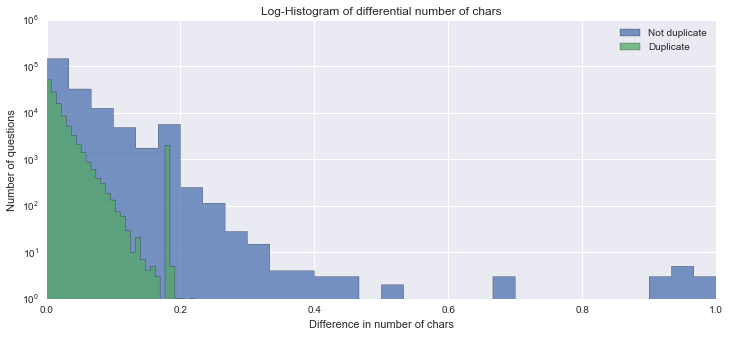

In [21]:
### Visualisation - plot histogram showing how distrubtion of differential number of chars between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_chars"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label="Not duplicate")
plt.hist(X_train["diff_num_chars"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of chars')
plt.xlabel('Difference in number of chars')
plt.ylabel('Number of questions')
plt.legend()
print

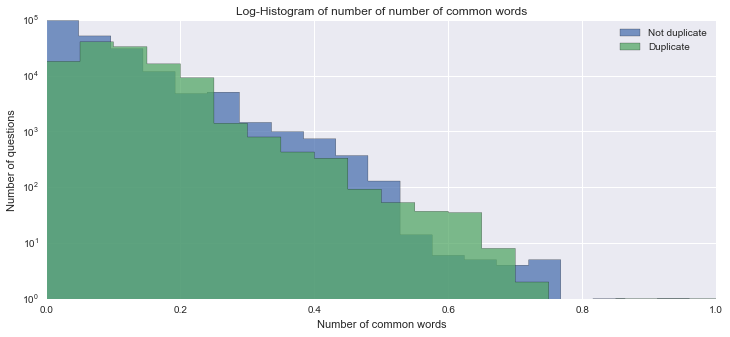

In [22]:
### Visualisation - plot histogram showing how distrubtion of number of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["num_common_words"][y_train == 0], bins=20, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["num_common_words"][y_train == 1], bins=20, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of number of number of common words')
plt.xlabel('Number of common words')
plt.ylabel('Number of questions')
plt.legend()
print

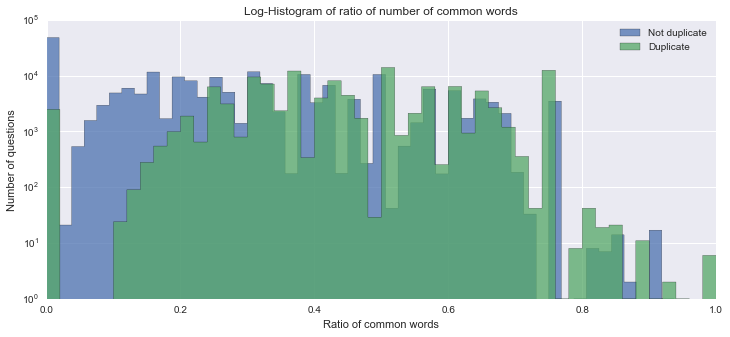

In [23]:
### Visualisation - plot histogram showing how distrubtion of ratio of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["ratio_common_words"][y_train == 0], bins=50, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["ratio_common_words"][y_train == 1], bins=50, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of ratio of number of common words')
plt.xlabel('Ratio of common words')
plt.ylabel('Number of questions')
plt.legend()
print

In [24]:
from sklearn.metrics import log_loss

def performance_metric(y_true, y_predict):
    """ Calculate and return the performance score between true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'  
    score = log_loss(y_true, y_predict)
    #print score
    
    # Return the score
    return score

In [25]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Perform grid search over the 'max_depth' parameter for a decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    print "DEBUG - making cv_sets"
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    

    print "DEBUG - making regressor"
    
    if algorithm_choice == 0:    #Linear Regression
        regressor = LinearRegression()
        params = {'fit_intercept':(True, False)}
        
    elif algorithm_choice == 1:  #SVR
        regressor = svm.SVR()
        params = {'C': (1,10)}
        
    elif algorithm_choice == 2:  #Decision Tree
        regressor = DecisionTreeRegressor()
        params = {'max_depth':(10, None)}
        
    elif algorithm_choice == 3:  #Random Forest
        regressor = RandomForestRegressor(n_estimators = 20)
        params = {'max_depth':(10, None)} 
          

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    print "DEBUG - making scorer"
    scoring_fnc = make_scorer(performance_metric)
    
    print "DEBUG - starting gridsearch"
    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets, verbose = 1)

    print "DEBUG - finished gridsearch, starting fit"
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    print "DEBUG - finished fit"

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [26]:
#Remove unnecessary feature
X_train.drop(["diff_num_chars"], axis = 1, inplace = True)
X_test.drop(["diff_num_chars"], axis = 1, inplace = True)
X_train.drop(["num_common_words"], axis = 1, inplace = True)
X_test.drop(["num_common_words"], axis = 1, inplace = True)
print "Removed unwanted features"

C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Removed unwanted features


C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
if algorithm_choice != 4: #calculate test predictions (in case of any algorithms except XGBoost)

    # Fit the training data to the model using grid search

    print "DEBUG - calling fit_model"
    reg = fit_model(X_train, y_train)

    # Print the optimal model parameters
    #print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
    print "Optimal model parameters: ", reg.get_params()
    
else:
    print "Skipping since using XGBoost"

Skipping since using XGBoost


In [28]:
if algorithm_choice != 4: #calculate test predictions (in case of any algorithms except XGBoost)
    print features_raw["question1"][3411], features_raw["question2"][3411]
    display(X_test.head())
    reg.predict(X_test.head())

    print performance_metric(y_test, reg.predict(X_test))
else:
    print "Skipping since using XGBoost"

Skipping since using XGBoost


In [29]:
import xgboost as xgb

if algorithm_choice == 4: #XGBoost

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

else:
    print "Skipping since not using XGBoost"


[0]	train-logloss:0.687217	valid-logloss:0.687164
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.638916	valid-logloss:0.638444
[20]	train-logloss:0.604857	valid-logloss:0.604104
[30]	train-logloss:0.580178	valid-logloss:0.579244
[40]	train-logloss:0.561927	valid-logloss:0.560884
[50]	train-logloss:0.548207	valid-logloss:0.547102
[60]	train-logloss:0.537235	valid-logloss:0.536074
[70]	train-logloss:0.52869	valid-logloss:0.527462
[80]	train-logloss:0.522389	valid-logloss:0.521148
[90]	train-logloss:0.51756	valid-logloss:0.516341
[100]	train-logloss:0.51352	valid-logloss:0.512317
[110]	train-logloss:0.510466	valid-logloss:0.509291
[120]	train-logloss:0.508061	valid-logloss:0.506933
[130]	train-logloss:0.506029	valid-logloss:0.504949
[140]	train-logloss:0.50445	valid-logloss:0.50342
[150]	train-logloss:0.503046	valid-logloss:0.502046
[160]	train-logloss:0.501923	vali

In [30]:
#Load the competition testing data set

try:
    test_data = pd.read_csv("test.csv")
    
    print "Quora duplicate questions competion test dataset has {} samples with {} features each.".format(*test_data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions competion test dataset has 2345796 samples with 3 features each.


In [31]:
#Pre-process competition test data in same was as training data
display(test_data.head())

#Make all text lower case
test_data["question1"] = test_data["question1"].apply(to_lower_case)
test_data["question2"] = test_data["question2"].apply(to_lower_case)

#Remove stop words
test_data["question1"] = test_data["question1"].apply(remove_stop_words)
test_data["question2"] = test_data["question2"].apply(remove_stop_words)

#Stem all words
test_data["question1"] = test_data["question1"].apply(stem_words)
test_data["question2"] = test_data["question2"].apply(stem_words)

test_data_features = pd.DataFrame()
test_data_features["diff_num_chars"] = test_data.apply(diff_num_chars, axis=1)
test_data_features["diff_num_words"] = test_data.apply(diff_num_words, axis=1)
test_data_features["num_common_words"] = test_data.apply(num_common_words, axis=1)
test_data_features["ratio_common_words"] = test_data.apply(ratio_common_words, axis=1)

display(test_data_features.head())

#min_max_scaler = preprocessing.MinMaxScaler()
feature_list = ["diff_num_chars", "diff_num_words", "num_common_words", "ratio_common_words"]

test_scaled_data = min_max_scaler.transform(test_data_features[feature_list])

test_features_scaled = pd.DataFrame(data = test_scaled_data, columns=feature_list)
display(test_features_scaled.head())

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,21,4,2,0.111111
1,4,0,2,0.200000
2,12,3,2,0.222222
3,6,0,1,0.250000
4,14,1,2,0.400000


,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,0.038391,0.04,0.08,0.166667
1,0.007313,0.00,0.08,0.300000
2,0.021938,0.03,0.08,0.333333
3,0.010969,0.00,0.04,0.375000
4,0.025594,0.01,0.08,0.600000


In [32]:
#Remove unnecessary feature
#test_data_features.drop(["diff_num_chars"], axis = 1, inplace = True)
#test_data_features.drop(["num_common_words"], axis = 1, inplace = True)
test_features_scaled.drop(["diff_num_chars"], axis = 1, inplace = True)
test_features_scaled.drop(["num_common_words"], axis = 1, inplace = True)
print "Removed unwanted features"

Removed unwanted features


In [33]:
if algorithm_choice == 4: #XGBoost
    d_test = xgb.DMatrix(test_features_scaled)
    #d_test = xgb.DMatrix(test_data_features)
    test_predictions = bst.predict(d_test)
else:  #Scikit-learn
    test_predictions = reg.predict(test_features_scaled)
    #test_predictions = reg.predict(test_features_scaled)

#print "Test_data_features shape: ", test_data_features.shape
#print "Test_predictions shape: ", test_predictions.shape
final_output = pd.concat([test_data["test_id"], pd.Series(test_predictions, name = "is_duplicate")], axis=1)

#print "Final output has {} samples with {} features each.".format(*final_output.shape)

display(final_output.head())

,test_id,is_duplicate
0,0,0.077318
1,1,0.464433
2,2,0.512888
3,3,0.516832
4,4,0.595737


In [34]:
final_output.to_csv("final_output.csv", index = False)
print "Final predictions written to final_output.csv successfully"

Final predictions written to final_output.csv successfully
